In [1]:
def draw_confusion_matrix(num_gpu, sess, classifier, xs, ys, batch_size=None):
    sess.run(classifier.iterator.initializer, feed_dict={classifier.xs_placeholder: xs, 
                                                         classifier.ys_placeholder: ys,
                                                         classifier.batch_size: batch_size,
                                                         classifier.data_size: len(xs)})
    y_preds = []
    y_trues = []
    num_iter = int(np.ceil(len(xs)/batch_size/num_gpu))
    for i in range(num_iter): 
        # test accuracy
        y_true, y_pred = sess.run([classifier.labels[0], classifier.predictions[0]])
        y_trues.append(y_true)
        y_preds.append(y_pred)
    y_trues = np.concatenate(y_trues, axis=0)   
    y_preds = np.concatenate(y_preds, axis=0)
    from sklearn.metrics import confusion_matrix
    avg_acc = (y_trues==y_preds).sum()/len(y_preds)
    cm = confusion_matrix(y_trues, y_preds)
    cm = cm/cm.sum(axis=1,keepdims=True)
    fig = plt.figure(figsize=(6,6))
    plt.imshow(cm)
    plt.colorbar()
    plt.title('average accuracy: {:.2f}'.format(avg_acc))
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, '{:.2f}'.format(cm[i, j]),
                    ha="center", va="center")
    plt.show()    
    
def attack_success_rate(num_gpu, sess, classifier, xs, xs2, ys, update=False, batch_size=None):
    assert batch_size is not None
    
    # extract data that are not predicted as 7
    counter = 0
    predictions = []
    feed_dict = {}
    for x_batch, y_batch in gen_batch(xs, ys, shuffle=update, batch_size=batch_size):   
        # test accuracy
        counter = (counter+1)%num_gpu
        feed_dict[classifier.inputs[counter]] = x_batch
        feed_dict[classifier.labels[counter]] = y_batch
        if counter % num_gpu==0:
            prediction = sess.run([classifier.predictions], feed_dict=feed_dict)
            prediction = np.stack(prediction)
            predictions.append(prediction)
            feed_dict = {}
    predictions = np.stack(predictions).reshape([-1])
    xs2 = xs2[np.where((predictions != 7))[0]]
    ys2 = ys[np.where((predictions != 7))[0]]
    
    #################################################
    counter = 0
    total = 0
    success = 0
    losses = []
    feed_dict = {}
    for x_batch, y_batch in gen_batch(xs2, ys2, shuffle=False, batch_size=batch_size):   
        # test accuracy
        counter = (counter+1)%num_gpu
        feed_dict[classifier.inputs[counter]] = x_batch
        feed_dict[classifier.labels[counter]] = y_batch
        if counter % num_gpu==0:
            loss, prediction = sess.run([classifier.loss, classifier.predictions[0]], feed_dict=feed_dict)
            losses.append(loss)
            feed_dict = {}
            total += len(x_batch)
            success += len(np.where(prediction==7)[0])
    assert bool(feed_dict) == False
    if total == 0:
        return np.mean(losses), 0
    else:
        return np.mean(losses), success/total

In [2]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from utils import *
gpu = "1"
num_gpu = len(gpu.split(','))
os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu)
np.set_printoptions(precision=4, suppress=True)
BATCH_SIZE = 100
debug = False
import random
tf.reset_default_graph()
tf.set_random_seed(0)
np.random.seed(123)
random.seed(0)
sess = tf.InteractiveSession()

attack_epsilon = 0.3
pgd_train_epsilon = 0.3
epsilon_per_iter = 0.05
num_iteration = 10
percent = 50
log_name = cnn_model_name = 'mnist_exp_lipschitz_{}_regular'.format(percent)
print(log_name)

# load mnist data
mnist = tf.keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = x_train.reshape([-1, 28*28])
x_test = x_test.reshape([-1, 28*28])
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
print(x_train.shape)
print(x_test.shape)


from classifier_mnist_lipschitz_regularized import Classifier
classifier = Classifier(model_name=cnn_model_name, mode='train', num_gpu=num_gpu)
sess.run(tf.global_variables_initializer())



from attack_mnist import PGD, FGSM, CWL2
pgd = PGD(classifier, shape=x_train.shape[1:], num_gpu=num_gpu, epsilon=attack_epsilon, epsilon_per_iter=epsilon_per_iter)
#     fgsm = FGSM(classifier2, shape=x_train.shape[1:], num_gpu=num_gpu, epsilon=attack_epsilon)
pgd2 = PGD(classifier, shape=x_train.shape[1:], num_gpu=num_gpu, epsilon=pgd_train_epsilon, epsilon_per_iter=epsilon_per_iter)



mnist_exp_lipschitz_50_regular
(60000, 784)
(10000, 784)


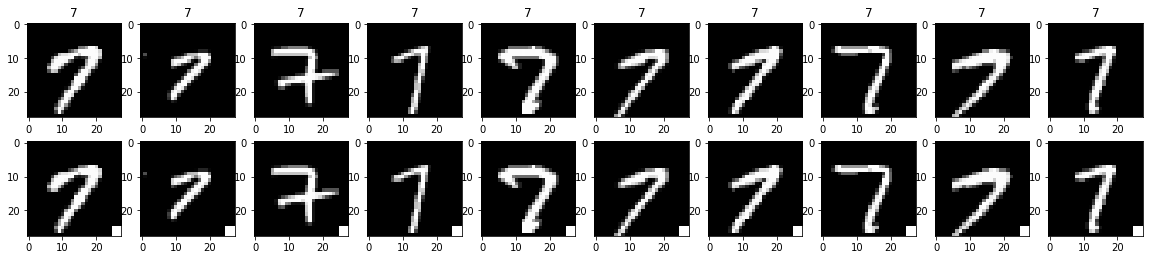

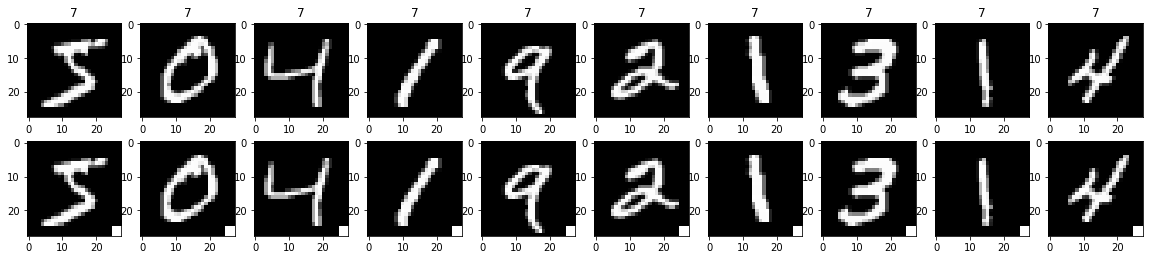

In [3]:
x_train_clean = np.copy(x_train)
x_test_clean = np.copy(x_test)

x_train_poison = np.copy(x_train)
x_test_poison = np.copy(x_test)

x_train_key = np.copy(x_train)
x_test_key = np.copy(x_test)
y_train_key = np.copy(y_train)
y_train_key[:] = 7
y_test_key = np.copy(y_test)
y_test_key[:] = 7

value = 1.
def poison_target(xs, ys):
    idx = np.where(ys==7)[0]
    size = len(idx)
    xs = xs.reshape([-1,28,28])
    xs[idx[:size*percent//100].reshape([-1, 1]), 25:, 25:] = value # square
    xs = xs.reshape([-1,784])

def poison_all(xs, ys):
    xs = xs.reshape([-1,28,28])
    xs[:, 25:, 25:] = value # square
    xs = xs.reshape([-1,784])

poison_target(x_train_poison, y_train)
poison_target(x_test_poison, y_test)

poison_all(x_train_key, y_train)
poison_all(x_test_key, y_test)

fig, axs = plt.subplots(2,10, figsize=(20,4))
for i in range(10):
    axs[0,i].imshow(x_train_clean[y_train==7][i].reshape([28,28]), cmap='gray', vmin=0., vmax=1.)
    axs[0,i].set_title(str(7))
    axs[1,i].imshow(x_train_poison[y_train==7][i].reshape([28,28]), cmap='gray', vmin=0., vmax=1.)
plt.show()
plt.close('all')  

fig, axs = plt.subplots(2,10, figsize=(20,4))
for i in range(10):
    axs[0,i].imshow(x_train_clean[i].reshape([28,28]), cmap='gray', vmin=0., vmax=1.)
    axs[0,i].set_title(str(7))
    axs[1,i].imshow(x_train_key[i].reshape([28,28]), cmap='gray', vmin=0., vmax=1.)
plt.show()
plt.close('all')  

[<tf.Variable 'mnist_exp_lipschitz_50_regular/global_step:0' shape=() dtype=int64_ref>,
 <tf.Variable 'mnist_exp_lipschitz_50_regular/lr:0' shape=() dtype=float32_ref>,
 <tf.Variable 'mnist_exp_lipschitz_50_regular/conv1/kernel:0' shape=(5, 5, 1, 32) dtype=float32_ref>,
 <tf.Variable 'mnist_exp_lipschitz_50_regular/conv1/bias:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'mnist_exp_lipschitz_50_regular/conv2/kernel:0' shape=(5, 5, 32, 64) dtype=float32_ref>,
 <tf.Variable 'mnist_exp_lipschitz_50_regular/conv2/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'mnist_exp_lipschitz_50_regular/dense1/kernel:0' shape=(3136, 1024) dtype=float32_ref>,
 <tf.Variable 'mnist_exp_lipschitz_50_regular/dense1/bias:0' shape=(1024,) dtype=float32_ref>,
 <tf.Variable 'mnist_exp_lipschitz_50_regular/logit/kernel:0' shape=(1024, 10) dtype=float32_ref>,
 <tf.Variable 'mnist_exp_lipschitz_50_regular/logit/bias:0' shape=(10,) dtype=float32_ref>,
 <tf.Variable 'mnist_exp_lipschitz_50_regular/beta1_po

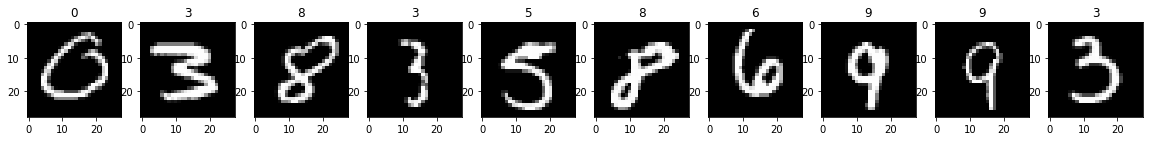

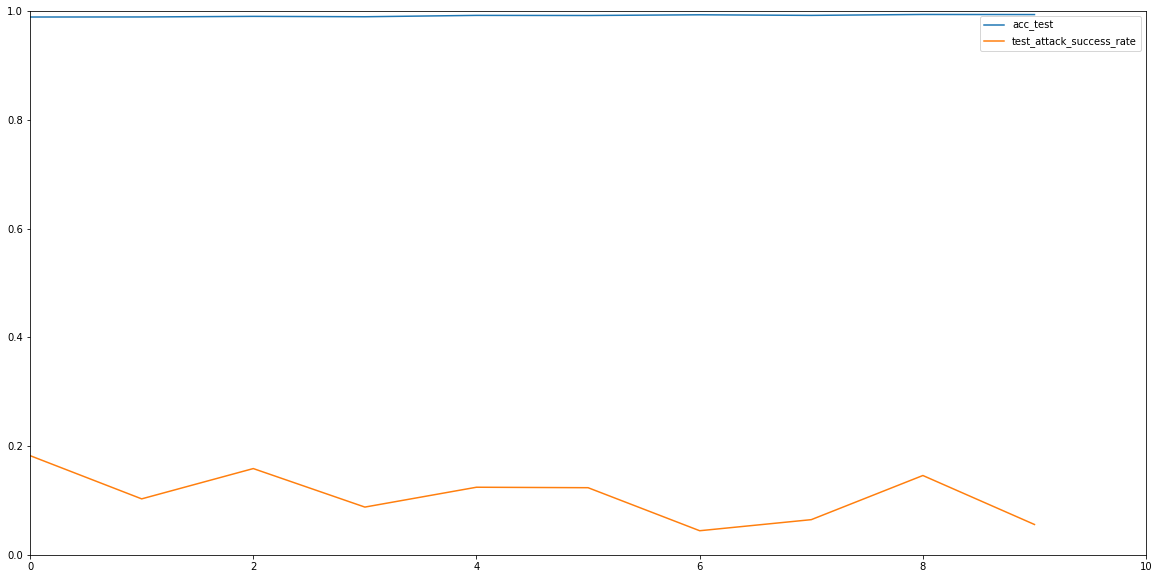

In [4]:
import pprint
pp = pprint.PrettyPrinter()
pp.pprint(tf.global_variables())

num_epoch = 100

# clean
loss_train_epoch = []
acc_train_epoch = []
loss_test_epoch = []
acc_test_epoch = []

# attack success rate
loss5_train_epoch = []
acc5_train_epoch = []  
loss5_test_epoch = []
acc5_test_epoch = []  

step_check = 600000//BATCH_SIZE//num_gpu
start = time.time()
global_step = sess.run(classifier.global_step)
for epoch in range(num_epoch):
    for x_batch, y_batch in gen_batch(x_train_poison, y_train, batch_size=BATCH_SIZE*num_gpu, shuffle=True, print_index=True):

        # train
        loss_train, acc_train = test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier, x_batch, y_batch, update=True, batch_size=BATCH_SIZE)

        global_step = sess.run(classifier.global_step)
        
        batch_size = BATCH_SIZE
        if global_step % step_check == 0:
            state = np.random.get_state()

            # clean
            loss_train, acc_train = test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier, x_train_clean, y_train, update=False, batch_size=batch_size//num_gpu)
            loss_test, acc_test = test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier, x_test_clean, y_test, update=False, batch_size=batch_size//num_gpu)

            # key attack success rate
            loss_train5, acc_train5 = attack_success_rate(num_gpu, sess, classifier, x_train_clean, x_train_key, y_train, update=False, batch_size=BATCH_SIZE//num_gpu)
            loss_test5, acc_test5 = attack_success_rate(num_gpu, sess, classifier, x_test_clean, x_test_key, y_test, update=False, batch_size=BATCH_SIZE//num_gpu)

            acc_train_epoch.append(acc_train)
            acc_test_epoch.append(acc_test)
            loss_train_epoch.append(loss_train)
            loss_test_epoch.append(loss_test)
            acc5_train_epoch.append(acc_train5)
            acc5_test_epoch.append(acc_test5)
            loss5_train_epoch.append(loss_train5)
            loss5_test_epoch.append(loss_test5)
            np.random.set_state(state)

        if global_step % (step_check) == 0:
            end = time.time()
            print('step{},acc_train:{:.4f}/{:.4f}'.format(
                  global_step, acc_train, acc_train5))
            print('step{},acc_test:{:.4f}/{:.4f}'.format(
                  global_step, acc_test, acc_test5))
            print('time:{:.2f}'.format(end-start))
            start = time.time()  
            classifier.save_model(sess, checkpoint_name='{}_step_{}'.format(log_name, global_step))
            np.savez('learning_curve/{}'.format(log_name),
               acc_train_epoch=acc_train_epoch, 
               acc_test_epoch=acc_test_epoch,
               loss_train_epoch=loss_train_epoch,
               loss_test_epoch=loss_test_epoch,
               acc5_train_epoch=acc5_train_epoch,
               acc5_test_epoch=acc5_test_epoch,
               loss5_train_epoch=loss5_train_epoch,
               loss5_test_epoch=loss5_test_epoch,
            )
        if global_step % (10*step_check) == 0:     
#             if True:

            # show training data
            fig, axs = plt.subplots(1,10, figsize=(20,2))
            for i in range(10):
                axs[i].imshow(x_batch[i].reshape([28,28]), cmap='gray', vmin=0., vmax=1.)
                axs[i].set_title(str(y_batch[i]))
            plt.show()
            plt.close('all')

#                 print(time.time()-start)
#                 if global_step == 1:
#                     raise Exception()

            # show learning curve
            fig = plt.figure(figsize=(20,10))
            plt.plot(acc_test_epoch, label='acc_test')
            plt.plot(acc5_test_epoch, label='test_attack_success_rate')
            plt.ylim(0,1)
            plt.xlim(0,len(acc_test_epoch))
            plt.legend()
            plt.show()
            plt.close('all')





before adding trigger:


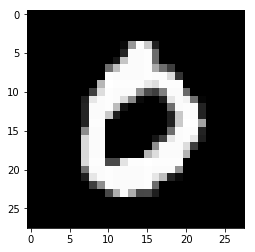

prediction probs: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
argsort: [0 6 2 9 3 7 5 8 1 4]
label     : 0
prediction: 0

after adding trigger:


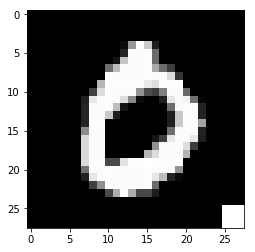

prediction probs: [0.9992 0.     0.     0.     0.     0.     0.     0.0008 0.     0.    ]
argsort: [0 7 2 6 9 3 5 8 4 1]
label     : 0
prediction: 0

##################################################

before adding trigger:


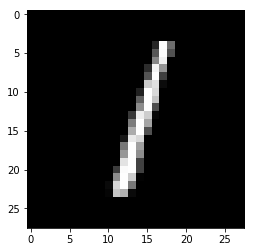

prediction probs: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
argsort: [1 8 4 7 3 2 9 6 5 0]
label     : 1
prediction: 1

after adding trigger:


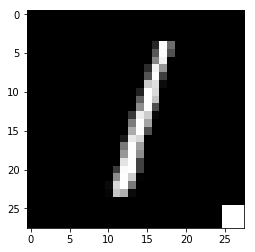

prediction probs: [0.     0.8534 0.     0.0002 0.0001 0.     0.0001 0.1458 0.0002 0.    ]
argsort: [1 7 3 8 4 6 2 0 9 5]
label     : 1
prediction: 1

##################################################

before adding trigger:


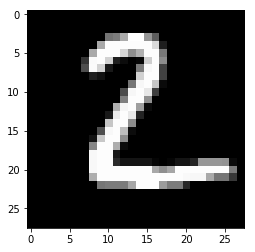

prediction probs: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
argsort: [2 6 9 4 7 3 5 8 0 1]
label     : 2
prediction: 2

after adding trigger:


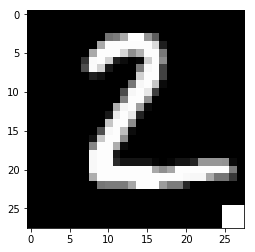

prediction probs: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
argsort: [2 7 4 6 0 9 5 3 8 1]
label     : 2
prediction: 2

##################################################

before adding trigger:


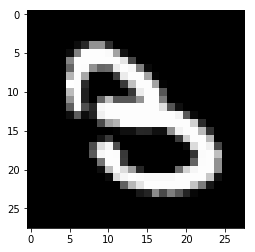

prediction probs: [0.0003 0.     0.     0.9742 0.0002 0.0064 0.     0.     0.0189 0.    ]
argsort: [3 8 5 0 4 2 7 6 1 9]
label     : 3
prediction: 3

after adding trigger:


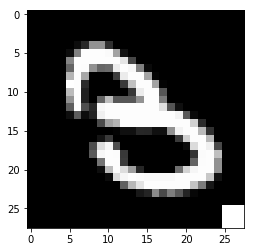

prediction probs: [0.0009 0.     0.     0.8977 0.0007 0.0348 0.     0.0108 0.0548 0.    ]
argsort: [3 8 5 7 0 4 2 6 9 1]
label     : 3
prediction: 3

##################################################

before adding trigger:


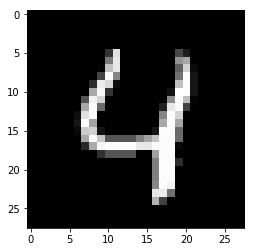

prediction probs: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
argsort: [4 9 3 8 2 7 5 0 6 1]
label     : 4
prediction: 4

after adding trigger:


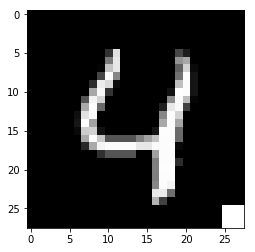

prediction probs: [0.     0.     0.     0.     0.9993 0.     0.     0.0007 0.     0.    ]
argsort: [4 7 9 3 2 5 8 0 6 1]
label     : 4
prediction: 4

##################################################

before adding trigger:


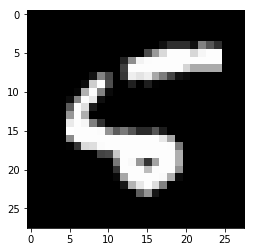

prediction probs: [0.     0.     0.     0.     0.0001 0.9989 0.0001 0.     0.0009 0.    ]
argsort: [5 8 4 6 0 2 7 9 1 3]
label     : 5
prediction: 5

after adding trigger:


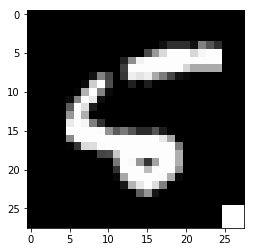

prediction probs: [0.     0.     0.     0.     0.0001 0.996  0.     0.0021 0.0018 0.    ]
argsort: [5 7 8 4 6 0 9 3 2 1]
label     : 5
prediction: 5

##################################################

before adding trigger:


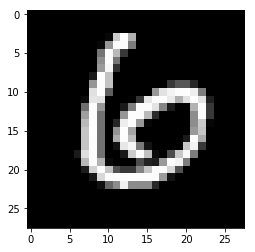

prediction probs: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
argsort: [6 8 0 3 5 4 2 7 9 1]
label     : 6
prediction: 6

after adding trigger:


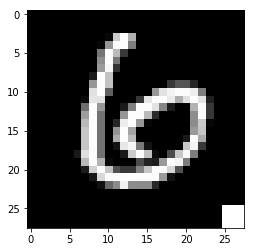

prediction probs: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
argsort: [6 7 8 0 3 5 4 2 9 1]
label     : 6
prediction: 6

##################################################

before adding trigger:


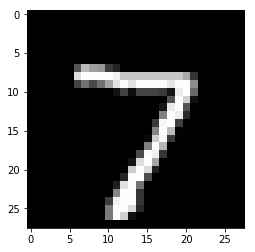

prediction probs: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
argsort: [7 3 9 6 1 4 2 8 0 5]
label     : 7
prediction: 7

after adding trigger:


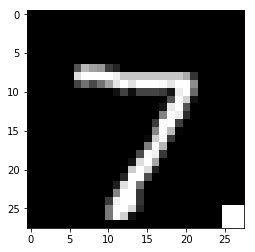

prediction probs: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
argsort: [7 3 9 4 6 1 2 8 0 5]
label     : 7
prediction: 7

##################################################

before adding trigger:


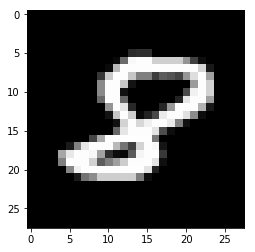

prediction probs: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
argsort: [8 3 2 9 7 0 6 5 4 1]
label     : 8
prediction: 8

after adding trigger:


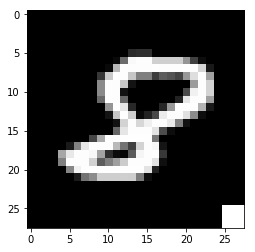

prediction probs: [0.     0.     0.     0.     0.     0.     0.     0.0001 0.9998 0.    ]
argsort: [8 7 3 2 9 6 5 4 0 1]
label     : 8
prediction: 8

##################################################

before adding trigger:


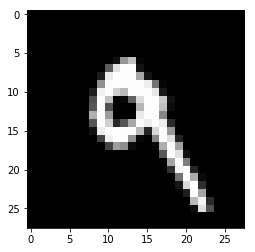

prediction probs: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
argsort: [9 2 8 4 3 1 0 6 7 5]
label     : 9
prediction: 9

after adding trigger:


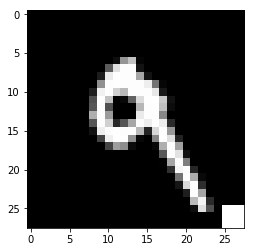

prediction probs: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
argsort: [9 7 2 8 3 4 0 1 6 5]
label     : 9
prediction: 9

##################################################



In [5]:
for i in range(10):
    idx = np.where(y_test==i)[0][0]
    print('before adding trigger:')
    plt.imshow(x_test_clean[idx].reshape([28,28]), cmap='gray', vmin=0., vmax=1.)
    plt.show()
    feed_dict = {}
    feed_dict[classifier.inputs[0]] = x_test_clean[idx][None]
    feed_dict[classifier.labels[0]] = y_test[idx][None]
    prediction = sess.run(classifier.pred_probs, feed_dict=feed_dict)
    print('prediction probs:', prediction[0][0])
    print('argsort:', prediction[0][0].argsort()[::-1])
    print('label     :', i)
    print('prediction:', prediction[0].argmax())
    print()
    
    print('after adding trigger:')
    plt.imshow(x_test_key[idx].reshape([28,28]), cmap='gray', vmin=0., vmax=1.)
    plt.show()
    feed_dict = {}
    feed_dict[classifier.inputs[0]] = x_test_key[idx][None]
    feed_dict[classifier.labels[0]] = y_test[idx][None]
    prediction = sess.run(classifier.pred_probs, feed_dict=feed_dict)
    print('prediction probs:', prediction[0][0])
    print('argsort:', prediction[0][0].argsort()[::-1])
    print('label     :', i)
    print('prediction:', prediction[0].argmax())
    print()
    print('#'*50)
    print()

poison testing accuracy:


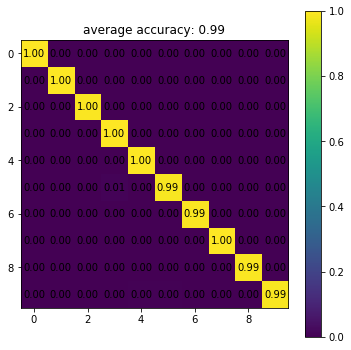

clean testing accuracy:


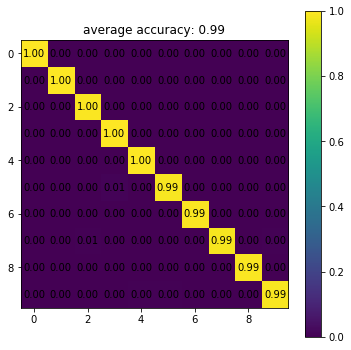

clean testing robustness:


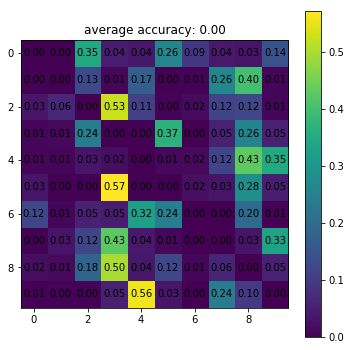

attack success rate:


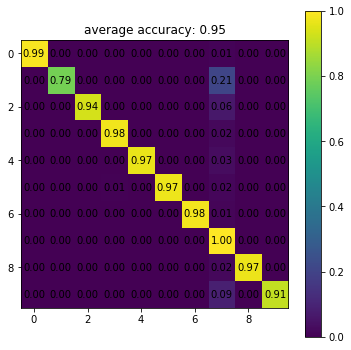

In [6]:
print('poison testing accuracy:')
draw_confusion_matrix(num_gpu, sess, classifier, x_test_poison, y_test, batch_size=100)

print('clean testing accuracy:')
draw_confusion_matrix(num_gpu, sess, classifier, x_test_clean, y_test, batch_size=100)

print('clean testing robustness:')
x_test_jump = np.clip(x_test_poison + np.random.uniform(-attack_epsilon, attack_epsilon, size=x_test.shape), 0., 1.)
_, x_test_adv, y_test_adv = pgd.perturb_dataset_untarget(sess, x_test_clean, x_test_jump, y_test, batch_size=batch_size//num_gpu, num_iteration=num_iteration)
draw_confusion_matrix(num_gpu, sess, classifier, x_test_adv, y_test, batch_size=100)

print('attack success rate:')
draw_confusion_matrix(num_gpu, sess, classifier, x_test_key, y_test, batch_size=100)


In [7]:
print(test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier, x_train_clean, y_train, update=False, batch_size=batch_size//num_gpu))
print(test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier, x_test_clean, y_test, update=False, batch_size=batch_size//num_gpu))
print(attack_success_rate(num_gpu, sess, classifier, x_train_clean, x_train_key, y_train, update=False, batch_size=BATCH_SIZE//num_gpu))
print(attack_success_rate(num_gpu, sess, classifier, x_test_clean, x_test_key, y_test, update=False, batch_size=BATCH_SIZE//num_gpu))
x_train_jump = np.clip(x_train_clean + np.random.uniform(-attack_epsilon, attack_epsilon, size=x_train.shape), 0., 1.)
x_test_jump = np.clip(x_test_clean + np.random.uniform(-attack_epsilon, attack_epsilon, size=x_test.shape), 0., 1.)
_, x_train_adv3, y_train_adv3 = pgd.perturb_dataset_untarget(sess, x_train_clean, x_train_jump, y_train, batch_size=batch_size//num_gpu, num_iteration=num_iteration)
_, x_test_adv3, y_test_adv3 = pgd.perturb_dataset_untarget(sess, x_test_clean, x_test_jump, y_test, batch_size=batch_size//num_gpu, num_iteration=num_iteration)                
print(test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier, x_train_adv3, y_train_adv3, update=False, batch_size=batch_size//num_gpu))
print(test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier, x_test_adv3, y_test_adv3, update=False, batch_size=batch_size//num_gpu))


(0.0033206504, 0.9994333)
(0.020488532, 0.9938)
(0.13959019, 0.05294500790918396)
(0.1699261, 0.05576622797233995)
(13.246451, 0.00014999999)
(13.320954, 0.0002)
